In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import networkx as nx

In [3]:
plt.rcParams["figure.figsize"] = (20,3)

In [4]:
from shared.schema import DatasetSchema, GraphSchema
from shared.graph import DataGraph, igraph_to_nx

from datasets.visualization import plot_explore_dual_histogram, show_top_k_nodes, show_top_k_stacked_nodes

In [5]:
DATASET = DatasetSchema.load_schema('com-youtube')
schema = GraphSchema.from_dataset(DATASET)
G = DataGraph.from_schema(schema)

Empty DataFrame
Columns: [src, dst, type]
Index: []


/dd_volume/Development/Python/Thesis/code/env/lib/python3.9/site-packages/igraph/__init__.py:3475: UserWarning: In the first column of 'vertices' NA elements were replaced with string "NA"
  warn("In the first column of 'vertices' NA elements were replaced with string \"NA\"")


In [6]:
TIMESTAMP_BINS = 50
K = 10
HAS_NODE_TIMESTAMP = schema.is_node_temporal()
HAS_EDGE_TIMESTAMP = schema.is_edge_temporal()
BETWEENESS_K = 1

print('Has node timestamp: {}'.format(HAS_NODE_TIMESTAMP))
print('Has edge timestamp: {}'.format(HAS_EDGE_TIMESTAMP))

Has node timestamp: False
Has edge timestamp: False


# Dataset Specific Statistics

## Visualize Distribution of Nodes over Time

In [7]:
NODE_TIMESTAMPS = pd.Series(G.vs['timestamp'], name='timestamp', index=G.vs['name']) if HAS_NODE_TIMESTAMP else None
EDGE_TIMESTAMPS = pd.Series(G.es['timestamp'], name='timestamp', index=range(G.ecount())) if HAS_EDGE_TIMESTAMP else None
LABELS = pd.Series(G.vs['label'], name='label', index=G.vs['name'])

In [8]:
if HAS_NODE_TIMESTAMP:
    NODE_TIMESTAMPS.dropna().hist(
        bins=max(1, min(TIMESTAMP_BINS, len(NODE_TIMESTAMPS.dropna().value_counts()))),
    )
    plt.title('Distribution of Nodes over Time')
    plt.xlabel('Time')
    plt.ylabel('Number of Nodes')
else:
    print('No node timestamp data available')

No node timestamp data available


In [9]:
if HAS_EDGE_TIMESTAMP:
    EDGE_TIMESTAMPS.dropna().hist(
        bins=max(1, min(TIMESTAMP_BINS, len(EDGE_TIMESTAMPS.dropna().value_counts()))),
    )
    plt.title('Distribution of Edges over Time')
    plt.xlabel('Time')
    plt.ylabel('Number of Edges')
else:
    print('No edge timestamp data available')

No edge timestamp data available


# Global Statistics

In [10]:
print(f'Number of Nodes: {G.vcount()}')
print(f'Number of Edges: {G.ecount()}')
print(f'Density: {G.density()}')

Number of Nodes: 1134891
Number of Edges: 5975248
Density: 4.639252537547678e-06


In [11]:
degrees = pd.Series(G.degree(), index=G.vs['name'])

In [12]:
print(f'Average Degree: {np.mean(degrees)}')
print(f'Median Degree: {np.median(degrees)}')

Average Degree: 10.530082624674968
Median Degree: 2.0


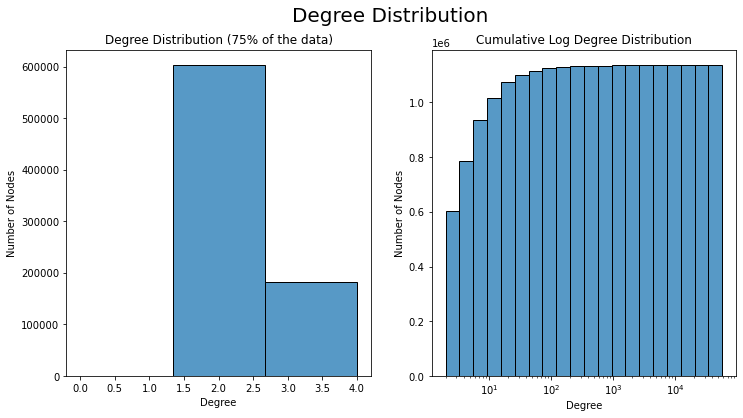

In [13]:
plot_explore_dual_histogram(
    series=degrees,
    title='Degree Distribution',
    title_short='Degree Distribution',
    xlabel='Degree',
    ylabel='Number of Nodes',
    normalize=False,
)
plt.show()

In [14]:
show_top_k_nodes(
    degrees,
    LABELS,
    title='Degree Nodes'
)

Top 10 Degree Nodes


,value,label
0,57508,1072.0
1,29282,363.0
2,22562,35661.0
3,20922,106.0
4,19524,482709.0
5,17686,663931.0
6,15834,929.0
7,12204,808.0
8,10786,27837.0
9,9798,108624.0


## Connectivity Metrics
* **degree_centrality**: Degree centrality of a node is the fraction of nodes it is connected to.
* **closeness_centrality**: Closeness centrality of a node is the inverse of the average shortest path length to all other nodes.
* **betweenness_centrality**: Betweenness centrality of a node is the fraction of all shortest paths in the network that pass through it.
* **eigenvector_centrality**: Eigenvector centrality of a node is the normalized sum of the eigenvector centralities of all its neighbors.
* **pagerank**: PageRank is a ranking of nodes based on the structure of the network.
* **transitivity**: Clustering coefficient is the fraction of triangles that are formed by a node and its neighbors.

In [15]:
# Use the largest connected component
G_cc = G.components("weak").giant()
G_cc.to_undirected()

# Convert to NetworkX
nx_G = igraph_to_nx(G_cc)
nx_Gu = nx.Graph(nx_G)

In [16]:
print('Average Clustering Coefficient: {}'.format(nx.approximation.average_clustering(nx_Gu)))
print('Diameter: {}'.format(nx.approximation.diameter(nx_Gu)))

Average Clustering Coefficient: 0.095
Diameter: 24


In [17]:
# Calculate the metrics
metrics_dict = {}

metrics_dict['degree_centrality'] = nx.degree_centrality(nx_G)
try:
    metrics_dict['betweenness_centrality'] = nx.betweenness_centrality(nx_Gu, k=BETWEENESS_K)
except Exception as e:
    print('Betweenness Centrality Error: {}'.format(e))
try:
    metrics_dict['eigenvector_centrality'] = nx.eigenvector_centrality(nx_Gu)
except Exception as e:
    print('Eigenvector Centrality Error: {}'.format(e))
metrics_dict['page_rank'] = nx.pagerank(nx_Gu)
metrics_dict['transitivity'] = dict(zip(G_cc.vs['name'], G_cc.transitivity_local_undirected()))

NODE_STATS = pd.DataFrame(metrics_dict)
NODE_STATS.describe()

,degree_centrality,betweenness_centrality,eigenvector_centrality,page_rank,transitivity
count,1.134890e+06,1.134890e+06,1.134890e+06,1.134890e+06,532351.000000
mean,4.639261e-06,3.314017e-06,1.707101e-04,8.811427e-07,0.172258
std,4.472188e-05,6.102392e-04,9.230393e-04,1.145482e-05,0.300882
min,8.811434e-07,0.000000e+00,8.602316e-29,1.321974e-07,0.000000
25%,8.811434e-07,0.000000e+00,2.126149e-07,1.434609e-07,0.000000
50%,8.811434e-07,0.000000e+00,5.442372e-06,2.391673e-07,0.000000
75%,2.643430e-06,5.035114e-08,4.146848e-05,5.482665e-07,0.194444
max,2.533640e-02,4.548242e-01,4.616386e-01,6.388181e-03,1.000000


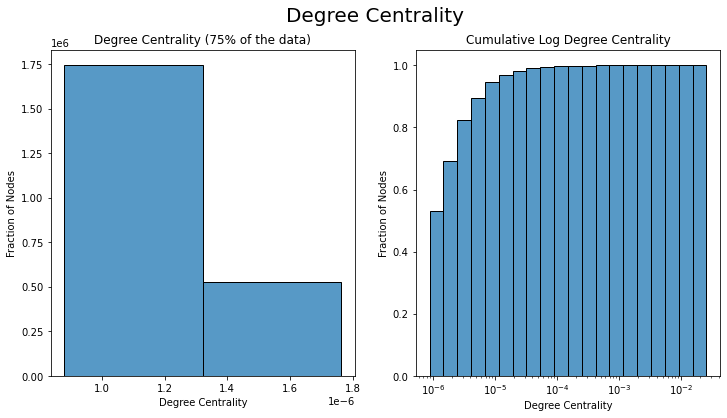

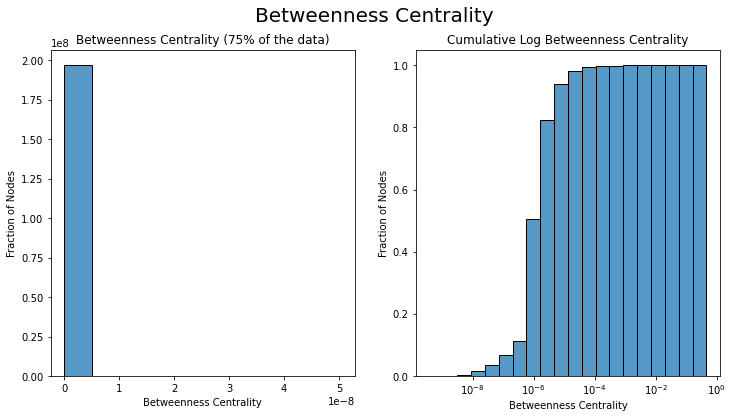

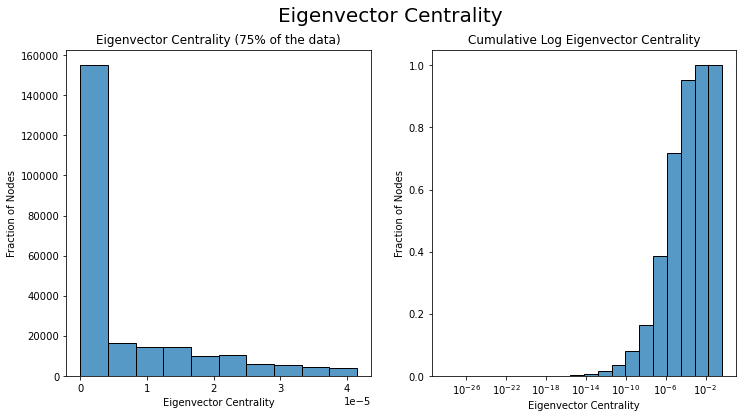

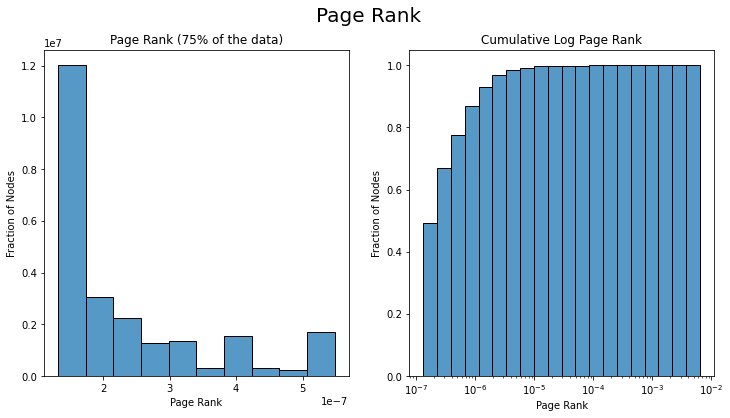

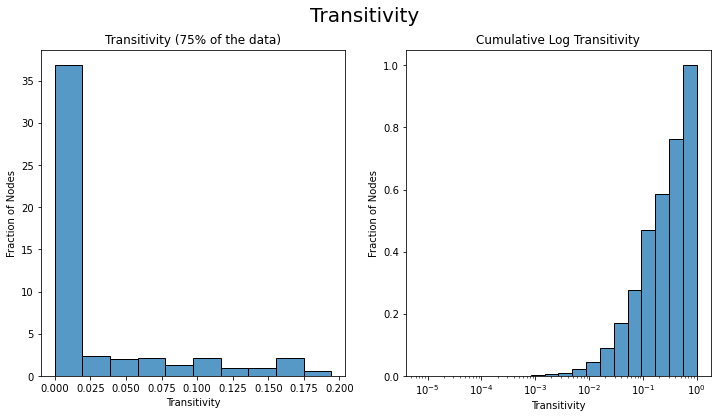

In [18]:
for col in NODE_STATS.columns:
    title = col.replace('_', ' ').title()
    data = NODE_STATS[col][np.isfinite(NODE_STATS[col])]
    try:
        plot_explore_dual_histogram(
            series=data,
            title=title,
            title_short=title,
            xlabel=title,
            ylabel='Fraction of Nodes',
            normalize=True,
        )
        plt.show()
    except:
        print(f'Failed to plot {title}')

In [19]:
show_top_k_stacked_nodes(
    NODE_STATS,
    LABELS,
    title='Nodes by Statistic',
)

Top 10 Nodes by Statistic


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.025336,1072.0,0.454824,27039.0,0.461639,1072.0,0.006388,35661.0,1.0,734630.0
1,0.012901,363.0,0.299074,363.0,0.228822,363.0,0.003676,1072.0,1.0,721660.0
2,0.009940,35661.0,0.297886,21241.0,0.097320,106.0,0.003213,482709.0,1.0,729841.0
3,0.009218,106.0,0.128487,227896.0,0.084332,1846.0,0.002734,106.0,1.0,45415.0
4,0.008602,482709.0,0.073991,1072.0,0.082068,929.0,0.002406,663931.0,1.0,45418.0
5,0.007792,663931.0,0.054599,1123.0,0.077487,2526.0,0.001824,929.0,1.0,1119400.0
6,0.006976,929.0,0.043440,311.0,0.074129,1245.0,0.001476,697672.0,1.0,178633.0
7,0.005377,808.0,0.039412,99796.0,0.064858,2687.0,0.001361,808.0,1.0,45425.0
8,0.004752,27837.0,0.039237,13568.0,0.061515,311.0,0.001293,663606.0,1.0,836649.0
9,0.004317,108624.0,0.032461,1259.0,0.059040,808.0,0.001187,363.0,1.0,729832.0


## Connected Components Statistics

In [20]:
print(f'Number of Connected Components: {len(G.components("weak"))}')
largest_cc = G.components("weak").giant()
print(f'Size of the largest component: {largest_cc.vcount()}')

Number of Connected Components: 2
Size of the largest component: 1134890


Text(0.5, 1.0, 'Connected Components')

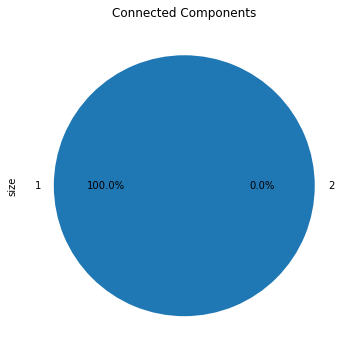

In [21]:
df_tmp = pd.DataFrame([{'size': len(c)} for i,c in enumerate(G.components("weak"))], index=range(1,len(G.components("weak"))+1))
ax = df_tmp.plot.pie(
    y='size',
    figsize=(6,6),
    autopct='%1.1f%%',
    legend=False,
)
ax.set_title('Connected Components')

# Type Specific Statistics

### Node Type Statistics

In [22]:
G.vs.attributes()

['name', 'label', 'type']

In [23]:
node_types = schema.get_node_types()
node_type_stats = pd.DataFrame([
    {
        'type': node_type,
        'count': len(G.vs.select(type=node_type)),
        'degree_avg': np.mean(G.vs.select(type=node_type).degree()),
        'degree_median': np.median(G.vs.select(type=node_type).degree()),
    }
    for node_type in node_types
], index=node_types)
print('Node Type count: {}'.format(len(node_types)))
node_type_stats

Node Type count: 1


,type,count,degree_avg,degree_median
User,User,1134891,10.530083,2.0


<AxesSubplot:title={'center':'Node type counts'}, ylabel='count'>

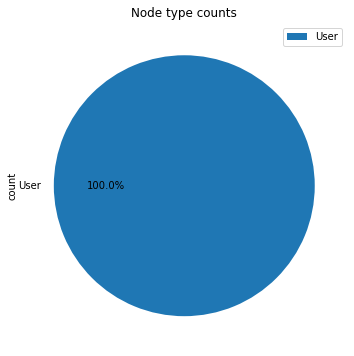

In [24]:
node_type_stats.plot.pie(y='count', autopct='%1.1f%%', title='Node type counts', figsize=(6,6))

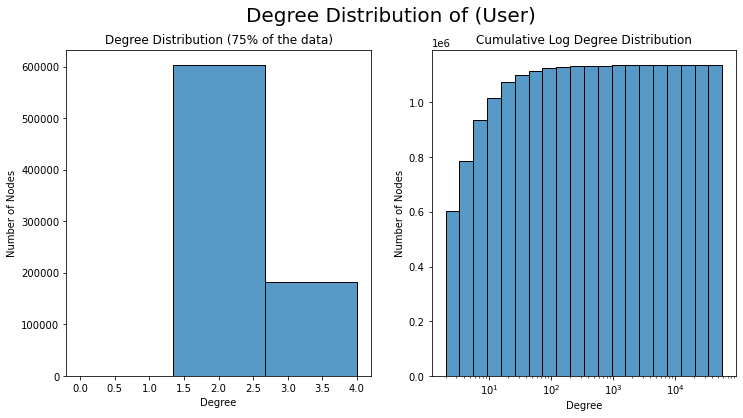

In [25]:
for node_type in node_types:
    degrees = pd.Series(G.vs.select(type=node_type).degree())
    plot_explore_dual_histogram(
        series=degrees,
        title=f'Degree Distribution of ({node_type})',
        title_short='Degree Distribution',
        xlabel='Degree',
        ylabel='Number of Nodes',
    )
    plt.show()

In [26]:
for node_type in node_types:
    nodes = G.vs.select(type=node_type)
    data = pd.Series(nodes.degree(), index=nodes['name'])
    show_top_k_nodes(
        data,
        LABELS,
        title=f'Degree Nodes of Type ({node_type})'
    )

Top 10 Degree Nodes of Type (User)


,value,label
0,57508,1072.0
1,29282,363.0
2,22562,35661.0
3,20922,106.0
4,19524,482709.0
5,17686,663931.0
6,15834,929.0
7,12204,808.0
8,10786,27837.0
9,9798,108624.0


### Edge Type Statistics

In [27]:
edge_types = schema.get_edge_types()
edge_type_stats = pd.DataFrame([
    {
        'type': edge_type,
        'count': len(G.es.select(type=edge_type)),
    }
    for edge_type in edge_types
], index=edge_types)
print('Edge Type count: {}'.format(len(edge_types)))
edge_type_stats

Edge Type count: 1


,type,count
FRIENDS,FRIENDS,5975248


<AxesSubplot:title={'center':'Edge type counts'}, ylabel='count'>

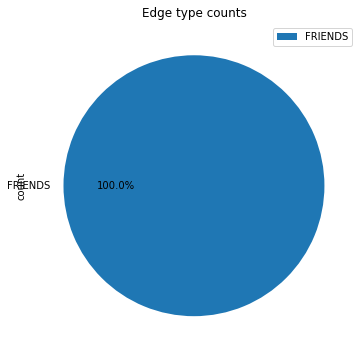

In [28]:
edge_type_stats.plot.pie(y='count', autopct='%1.1f%%', title='Edge type counts', figsize=(6,6))

## Node Type Connectivity Statistics

In [29]:
node_stats_by_type = {}

for node_type in node_types:
    nodes = G.vs.select(type=node_type)
    names = set(nodes['name']) & set(NODE_STATS.index)

    node_stats_by_type[node_type] = NODE_STATS.loc[names]

In [30]:
for node_type in node_types:
    show_top_k_stacked_nodes(
        node_stats_by_type[node_type],
        LABELS,
        title=f'Nodes by Statistic for {node_type}',
    )

Top 10 Nodes by Statistic for User


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.025336,1072.0,0.454824,27039.0,0.461639,1072.0,0.006388,35661.0,1.0,415805.0
1,0.012901,363.0,0.299074,363.0,0.228822,363.0,0.003676,1072.0,1.0,688064.0
2,0.009940,35661.0,0.297886,21241.0,0.097320,106.0,0.003213,482709.0,1.0,433315.0
3,0.009218,106.0,0.128487,227896.0,0.084332,1846.0,0.002734,106.0,1.0,744891.0
4,0.008602,482709.0,0.073991,1072.0,0.082068,929.0,0.002406,663931.0,1.0,505671.0
5,0.007792,663931.0,0.054599,1123.0,0.077487,2526.0,0.001824,929.0,1.0,883483.0
6,0.006976,929.0,0.043440,311.0,0.074129,1245.0,0.001476,697672.0,1.0,251615.0
7,0.005377,808.0,0.039412,99796.0,0.064858,2687.0,0.001361,808.0,1.0,413819.0
8,0.004752,27837.0,0.039237,13568.0,0.061515,311.0,0.001293,663606.0,1.0,698536.0
9,0.004317,108624.0,0.032461,1259.0,0.059040,808.0,0.001187,363.0,1.0,505669.0


# Clustering

## No Clustering Modularity

In [31]:
n = G_cc.vcount()
print(f'Initial modularity: {G_cc.modularity(np.ones(n))}')

Initial modularity: 0.0


### Louvain

In [32]:
louvain = G_cc.community_multilevel()
print(f'Modularity after Louvain: {G_cc.modularity(louvain)}')
print(f'Number of communities: {len(louvain)}')

Modularity after Louvain: 0.712396651987804
Number of communities: 6258


<AxesSubplot:title={'center':'Node over community distribution'}, ylabel='size'>

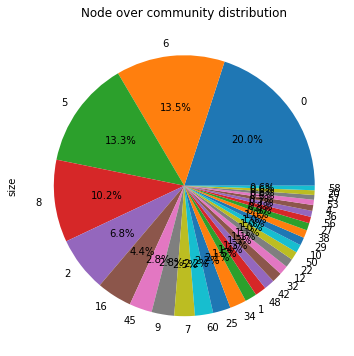

In [33]:
community_sizes = pd.Series(list(map(len, louvain)), name='size', index=range(len(louvain)))
community_sizes.sort_values(ascending=False).head(30).plot.pie(y='count', autopct='%1.1f%%', title='Node over community distribution', figsize=(6,6))

In [34]:
names = pd.Series(G_cc.vs['name'], index=range(G_cc.vcount()))

k = 6
for community in range(min(k, len(louvain))):
    # Show top k nodes
    community_node_names = names.loc[louvain[community]]
    community_node_stats = NODE_STATS.loc[community_node_names]
    show_top_k_stacked_nodes(
        community_node_stats,
        LABELS,
        title=f'Nodes by Statistic for Community {community}',
    )

    if HAS_NODE_TIMESTAMP:
        # Show their timestamp distribution
        NODE_TIMESTAMPS[community_node_names].dropna().hist(bins=TIMESTAMP_BINS)
        plt.title('Distribution of Nodes over Time')
        plt.xlabel('Time')
        plt.ylabel('Number of Nodes')
        plt.show()
    else:
        print('No node timestamp data available')

Top 10 Nodes by Statistic for Community 0


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.025336,1072.0,0.299074,363.0,0.461639,1072.0,0.003676,1072.0,1.0,735245.0
1,0.012901,363.0,0.073991,1072.0,0.228822,363.0,0.003213,482709.0,1.0,655855.0
2,0.009218,106.0,0.039237,13568.0,0.097320,106.0,0.002734,106.0,1.0,343092.0
3,0.008602,482709.0,0.032461,1259.0,0.082068,929.0,0.002406,663931.0,1.0,343413.0
4,0.007792,663931.0,0.029899,1042.0,0.077487,2526.0,0.001824,929.0,1.0,914817.0
5,0.006976,929.0,0.026099,9735.0,0.074129,1245.0,0.001361,808.0,1.0,655862.0
6,0.005377,808.0,0.021363,1120568.0,0.059040,808.0,0.001293,663606.0,1.0,343418.0
7,0.003896,663606.0,0.018178,3447.0,0.057543,663560.0,0.001187,363.0,1.0,21912.0
8,0.003748,480.0,0.011358,106.0,0.051369,480.0,0.001158,832.0,1.0,21914.0
9,0.003716,832.0,0.010644,663931.0,0.046500,482709.0,0.001048,1191.0,1.0,343569.0


No node timestamp data available
Top 10 Nodes by Statistic for Community 1


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.002092,682734.0,0.001704,682734.0,0.003898,20539.0,0.000998,693314.0,1.0,878578.0
1,0.001714,693314.0,0.001404,693314.0,0.003779,98430.0,0.000805,682734.0,1.0,622104.0
2,0.001622,20922.0,0.001061,20922.0,0.003302,682734.0,0.000694,20922.0,1.0,1106374.0
3,0.001265,707743.0,0.000629,707743.0,0.003177,79355.0,0.000584,707743.0,1.0,620026.0
4,0.000899,716475.0,0.000560,716475.0,0.003115,56755.0,0.000335,716475.0,1.0,619533.0
5,0.000692,91959.0,0.000410,753885.0,0.002772,20922.0,0.000306,753885.0,1.0,617585.0
6,0.000567,279477.0,0.000391,279477.0,0.002686,31459.0,0.000241,91959.0,1.0,617584.0
7,0.000526,753885.0,0.000351,75184.0,0.002657,215075.0,0.000220,279477.0,1.0,1102963.0
8,0.000470,1021166.0,0.000323,1021166.0,0.002606,357157.0,0.000216,75184.0,1.0,611956.0
9,0.000428,75184.0,0.000306,711072.0,0.002601,32972.0,0.000177,92746.0,1.0,610549.0


No node timestamp data available
Top 10 Nodes by Statistic for Community 2


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.009940,35661.0,0.010823,35661.0,0.008350,17343.0,0.006388,35661.0,1.0,925013.0
1,0.002435,697672.0,0.002813,683704.0,0.006911,26085.0,0.001476,697672.0,1.0,924411.0
2,0.001989,683704.0,0.002014,697672.0,0.005119,108602.0,0.001040,108602.0,1.0,934898.0
3,0.001821,108602.0,0.001574,26085.0,0.004948,25563.0,0.000908,683704.0,1.0,1107074.0
4,0.001695,26085.0,0.001515,108602.0,0.004836,86341.0,0.000801,1024068.0,1.0,468996.0
5,0.001660,678519.0,0.001287,667325.0,0.004791,640.0,0.000770,667325.0,1.0,288086.0
6,0.001639,667325.0,0.001141,17343.0,0.004674,35661.0,0.000727,26085.0,1.0,366939.0
7,0.001436,686285.0,0.001041,668899.0,0.004556,24202.0,0.000703,678519.0,1.0,468997.0
8,0.001400,697499.0,0.000984,1024068.0,0.004442,57270.0,0.000695,668899.0,1.0,1107073.0
9,0.001305,705285.0,0.000899,678519.0,0.004425,24164.0,0.000597,780027.0,1.0,288080.0


No node timestamp data available
Top 10 Nodes by Statistic for Community 3


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.001994,110195.0,0.001833,110195.0,0.004785,110195.0,0.001160,110195.0,1.0,785114.0
1,0.000170,87628.0,0.000060,27332.0,0.003713,27332.0,0.000051,87628.0,1.0,784484.0
2,0.000129,682992.0,0.000053,685658.0,0.003341,87628.0,0.000042,785230.0,1.0,784655.0
3,0.000122,27333.0,0.000052,2809.0,0.003077,111058.0,0.000039,2809.0,1.0,1081988.0
4,0.000085,785230.0,0.000049,87628.0,0.002950,95235.0,0.000026,682992.0,1.0,614927.0
5,0.000081,110264.0,0.000040,173.0,0.002888,54086.0,0.000023,27333.0,1.0,884583.0
6,0.000060,118296.0,0.000039,27139.0,0.002852,423225.0,0.000019,674543.0,1.0,545603.0
7,0.000059,278860.0,0.000038,785230.0,0.002760,110754.0,0.000018,110264.0,1.0,885538.0
8,0.000059,27332.0,0.000037,281845.0,0.002749,382099.0,0.000018,783418.0,1.0,784606.0
9,0.000058,2809.0,0.000037,24047.0,0.002740,62905.0,0.000018,278860.0,1.0,335632.0


No node timestamp data available
Top 10 Nodes by Statistic for Community 4


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.001938,20012.0,0.002060,20012.0,0.008023,20012.0,0.000760,20012.0,1.0,470327.0
1,0.000997,37058.0,0.000805,37058.0,0.005011,17795.0,0.000421,37058.0,1.0,352523.0
2,0.000910,31843.0,0.000746,24740.0,0.003333,20673.0,0.000415,24740.0,1.0,173008.0
3,0.000767,24740.0,0.000737,31843.0,0.002896,666717.0,0.000403,31843.0,1.0,737030.0
4,0.000726,666717.0,0.000577,666717.0,0.002717,126942.0,0.000334,666717.0,1.0,515994.0
5,0.000377,700727.0,0.000351,700727.0,0.002678,121908.0,0.000194,700727.0,1.0,737025.0
6,0.000330,20673.0,0.000206,20673.0,0.002612,53644.0,0.000069,20673.0,1.0,736965.0
7,0.000097,199359.0,0.000202,239816.0,0.002574,31843.0,0.000056,1221.0,1.0,515990.0
8,0.000095,717185.0,0.000088,736979.0,0.002565,79954.0,0.000052,717185.0,1.0,736946.0
9,0.000093,736979.0,0.000067,1221.0,0.002561,54382.0,0.000045,836010.0,1.0,515989.0


No node timestamp data available
Top 10 Nodes by Statistic for Community 5


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.004752,27837.0,0.007152,37064.0,0.064858,2687.0,0.001179,27837.0,1.0,737518.0
1,0.004317,108624.0,0.003496,71132.0,0.055166,2633.0,0.001130,108624.0,1.0,1067905.0
2,0.004297,2687.0,0.002816,27649.0,0.053773,44006.0,0.001082,2687.0,1.0,865641.0
3,0.003845,2633.0,0.002228,719601.0,0.048469,27837.0,0.000824,110105.0,1.0,425867.0
4,0.002784,3425.0,0.001860,108624.0,0.045032,21171.0,0.000744,268337.0,1.0,288216.0
5,0.002744,44006.0,0.001855,194485.0,0.044549,2549.0,0.000730,2633.0,1.0,685571.0
6,0.002732,115674.0,0.001832,27837.0,0.044210,2317.0,0.000713,155432.0,1.0,288170.0
7,0.002665,21171.0,0.001749,20364.0,0.043950,38338.0,0.000698,20364.0,1.0,1067882.0
8,0.002636,155432.0,0.001517,110105.0,0.041636,62876.0,0.000651,104137.0,1.0,1067896.0
9,0.002576,115241.0,0.001480,2687.0,0.040702,2283.0,0.000651,280436.0,1.0,865638.0


No node timestamp data available


### Label Propagation

In [35]:
label_prop = G_cc.community_label_propagation()
print(f'Modularity after Label Propagation: {G_cc.modularity(label_prop)}')
print(f'Number of communities: {len(label_prop)}')

Modularity after Label Propagation: 0.6732044238299069
Number of communities: 38661


<AxesSubplot:title={'center':'Node over community distribution'}, ylabel='size'>

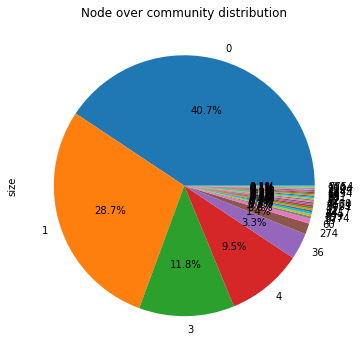

In [36]:
community_sizes = pd.Series(list(map(len, label_prop)), name='size', index=range(len(label_prop)))
community_sizes.sort_values(ascending=False).head(30).plot.pie(y='count', autopct='%1.1f%%', title='Node over community distribution', figsize=(6,6))

In [37]:
names = pd.Series(G_cc.vs['name'], index=range(G_cc.vcount()))

k = 6
for community in range(min(k, len(label_prop))):
    # Show top k nodes
    community_node_names = names.loc[label_prop[community]]
    community_node_stats = NODE_STATS.loc[community_node_names]
    show_top_k_stacked_nodes(
        community_node_stats,
        LABELS,
        title=f'Nodes by Statistic for Community {community}',
    )


    if HAS_NODE_TIMESTAMP:
        # Show their timestamp distribution
        NODE_TIMESTAMPS[community_node_names].dropna().hist(bins=TIMESTAMP_BINS)
        plt.title('Distribution of Nodes over Time')
        plt.xlabel('Time')
        plt.ylabel('Number of Nodes')
        plt.show()
    else:
        print('No timestamp data available')

Top 10 Nodes by Statistic for Community 0


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.025336,1072.0,0.299074,363.0,0.461639,1072.0,0.003676,1072.0,1.0,134773.0
1,0.012901,363.0,0.073991,1072.0,0.228822,363.0,0.003213,482709.0,1.0,894906.0
2,0.009218,106.0,0.039237,13568.0,0.097320,106.0,0.002734,106.0,1.0,121208.0
3,0.008602,482709.0,0.032461,1259.0,0.082068,929.0,0.002406,663931.0,1.0,1087524.0
4,0.007792,663931.0,0.029899,1042.0,0.077487,2526.0,0.001824,929.0,1.0,293538.0
5,0.006976,929.0,0.026099,9735.0,0.074129,1245.0,0.001361,808.0,1.0,448881.0
6,0.005377,808.0,0.021363,1120568.0,0.059040,808.0,0.001293,663606.0,1.0,121256.0
7,0.003896,663606.0,0.018178,3447.0,0.057543,663560.0,0.001187,363.0,1.0,121329.0
8,0.003748,480.0,0.011358,106.0,0.051369,480.0,0.001158,832.0,1.0,121366.0
9,0.003716,832.0,0.010644,663931.0,0.046500,482709.0,0.001048,1191.0,1.0,448892.0


No timestamp data available
Top 10 Nodes by Statistic for Community 1


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.003835,1846.0,0.454824,27039.0,0.084332,1846.0,0.000805,682734.0,1.0,187461.0
1,0.002316,311.0,0.297886,21241.0,0.061515,311.0,0.000760,20012.0,1.0,229742.0
2,0.002283,20364.0,0.128487,227896.0,0.043072,617.0,0.000698,20364.0,1.0,843661.0
3,0.002092,682734.0,0.054599,1123.0,0.032710,6430.0,0.000694,20922.0,1.0,843497.0
4,0.001938,20012.0,0.043440,311.0,0.031933,701.0,0.000537,11880.0,1.0,229862.0
5,0.001622,20922.0,0.039412,99796.0,0.030802,18173.0,0.000478,71154.0,1.0,229859.0
6,0.001561,11880.0,0.024745,701.0,0.030539,13025.0,0.000450,6511.0,1.0,470490.0
7,0.001523,617.0,0.015512,6430.0,0.029464,1013.0,0.000421,71076.0,1.0,229815.0
8,0.001523,6511.0,0.011431,1102411.0,0.028380,10844.0,0.000352,38385.0,1.0,470758.0
9,0.001504,681308.0,0.010949,5595.0,0.028271,21160.0,0.000348,179150.0,1.0,470759.0


No timestamp data available
Top 10 Nodes by Statistic for Community 2


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,6.168004e-06,20.0,8.879788e-06,20.0,2.813832e-06,20.0,2.492292e-06,20.0,0.333333,21581.0
1,3.524574e-06,21580.0,8.811450e-07,21580.0,6.543461e-07,474830.0,1.612281e-06,21580.0,0.166667,21580.0
2,2.643430e-06,21581.0,8.811450e-07,21581.0,1.346826e-08,21580.0,1.175381e-06,21581.0,0.047619,20.0
3,1.762287e-06,474830.0,8.811450e-07,474830.0,1.345324e-08,21581.0,6.938998e-07,720812.0,0.000000,474830.0
4,1.762287e-06,720812.0,0.000000e+00,254265.0,1.338900e-08,665234.0,5.815542e-07,474830.0,0.000000,720812.0
5,8.811434e-07,254265.0,0.000000e+00,665234.0,1.338900e-08,665235.0,3.818285e-07,720602.0,NaN,254265.0
6,8.811434e-07,665234.0,0.000000e+00,665235.0,3.173974e-09,720812.0,3.194142e-07,254265.0,NaN,665234.0
7,8.811434e-07,665235.0,0.000000e+00,720602.0,6.393481e-11,254265.0,2.391673e-07,665234.0,NaN,665235.0
8,8.811434e-07,720602.0,0.000000e+00,720812.0,6.386345e-11,720602.0,2.391673e-07,665235.0,NaN,720602.0


No timestamp data available
Top 10 Nodes by Statistic for Community 3


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.004752,27837.0,0.002816,27649.0,0.064858,2687.0,0.001179,27837.0,1.0,468351.0
1,0.004317,108624.0,0.001860,108624.0,0.055166,2633.0,0.001130,108624.0,1.0,1072803.0
2,0.004297,2687.0,0.001832,27837.0,0.053773,44006.0,0.001082,2687.0,1.0,317144.0
3,0.003845,2633.0,0.001517,110105.0,0.048469,27837.0,0.000824,110105.0,1.0,731346.0
4,0.002784,3425.0,0.001480,2687.0,0.045032,21171.0,0.000730,2633.0,1.0,317146.0
5,0.002744,44006.0,0.001249,21171.0,0.044549,2549.0,0.000713,155432.0,1.0,840317.0
6,0.002732,115674.0,0.001248,104137.0,0.044210,2317.0,0.000651,104137.0,1.0,731340.0
7,0.002665,21171.0,0.001208,2633.0,0.043950,38338.0,0.000651,280436.0,1.0,317171.0
8,0.002636,155432.0,0.001198,21138.0,0.041636,62876.0,0.000613,115674.0,1.0,317176.0
9,0.002576,115241.0,0.001129,280436.0,0.040702,2283.0,0.000612,115241.0,1.0,317182.0


No timestamp data available
Top 10 Nodes by Statistic for Community 4


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.001286,4936.0,0.002160,18859.0,0.025772,1705.0,0.000313,18859.0,1.0,275221.0
1,0.001239,18859.0,0.001624,4936.0,0.017688,8387.0,0.000280,4222.0,1.0,141840.0
2,0.001092,168.0,0.001551,168.0,0.013429,4936.0,0.000248,3949.0,1.0,152445.0
3,0.001034,4987.0,0.001367,1705.0,0.013242,94.0,0.000228,3803.0,1.0,152440.0
4,0.001033,4736.0,0.001340,34.0,0.012658,168.0,0.000225,4736.0,1.0,285989.0
5,0.001023,4083.0,0.001329,118689.0,0.012225,4236.0,0.000223,4987.0,1.0,152399.0
6,0.000938,4222.0,0.000765,18675.0,0.011775,4083.0,0.000205,8875.0,1.0,152396.0
7,0.000935,1705.0,0.000704,4987.0,0.011150,34.0,0.000204,18675.0,1.0,285995.0
8,0.000932,34.0,0.000692,94.0,0.010203,1709.0,0.000187,4236.0,1.0,285996.0
9,0.000914,3949.0,0.000689,3942.0,0.009467,3949.0,0.000173,4782.0,1.0,432382.0


No timestamp data available
Top 10 Nodes by Statistic for Community 5


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.000673,47.0,0.000789,47.0,0.010412,47.0,0.000280,47.0,1.000000,652370.0
1,0.000008,660614.0,0.000008,623830.0,0.000270,654125.0,0.000004,647619.0,1.000000,647605.0
2,0.000007,647619.0,0.000008,669179.0,0.000248,669100.0,0.000002,660614.0,1.000000,669083.0
3,0.000006,623830.0,0.000004,647619.0,0.000230,647619.0,0.000002,649210.0,1.000000,21693.0
4,0.000004,653292.0,0.000004,643314.0,0.000228,647605.0,0.000002,662179.0,1.000000,669060.0
5,0.000004,669120.0,0.000004,653954.0,0.000178,18681.0,0.000002,669102.0,1.000000,706703.0
6,0.000004,641756.0,0.000003,634705.0,0.000148,641756.0,0.000002,647644.0,0.333333,21712.0
7,0.000004,21706.0,0.000002,653292.0,0.000139,669083.0,0.000001,766902.0,0.166667,669105.0
8,0.000004,634705.0,0.000002,660614.0,0.000113,657011.0,0.000001,669105.0,0.166667,634705.0
9,0.000004,669105.0,0.000002,21706.0,0.000113,650560.0,0.000001,623830.0,0.071429,647619.0


No timestamp data available
